# Classification Algorithms and Resampling Methods

For this supervised classification problem I will be answering: what is the probability a given person will default on a personal loan? I am building a model that is going to predict if a person will default on a loan given that their loan status is not defaulted.
    
The training set consists of 2260668 rows and 108 columns with 40 negative examples of defaulted loans.
    
Two specific classification models I will be testing are **Logistic Regression** and **Random Forest Classifier**.

In [102]:
import numpy as np
import pandas as pd
import pickle
import datetime

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings(action = 'ignore')

In [34]:
with open('lending_club_missingvals_pick.pkl', 'rb') as pickle_file:
    df = pickle.load(pickle_file)

In [35]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,TARGET
0,3600.0,3600.0,3600.0,36,13.99,123.03,C,C4,10,MORTGAGE,...,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N,0
1,24700.0,24700.0,24700.0,36,11.99,820.28,C,C1,10,MORTGAGE,...,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N,0
2,20000.0,20000.0,20000.0,60,10.78,432.66,B,B4,10,MORTGAGE,...,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N,0
3,35000.0,35000.0,35000.0,60,14.85,829.90,C,C5,10,MORTGAGE,...,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,N,0
4,10400.0,10400.0,10400.0,60,22.45,289.91,F,F1,3,MORTGAGE,...,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N,0


## Label Encoding, Ordinal Encoding, and Dummy Variables

Text(0, 0.5, 'Data type')

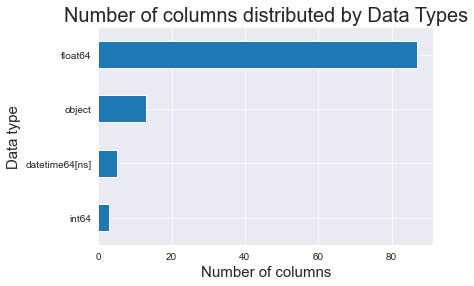

In [36]:
df.dtypes.value_counts().sort_values().plot(kind='barh')
plt.title('Number of columns distributed by Data Types',fontsize=20)
plt.xlabel('Number of columns',fontsize=15)
plt.ylabel('Data type',fontsize=15)

For the categorical 'O' dtypes I subset the features by ordered and unordered to use ordinal encoder and dummy variables respectively. Features with 2 or fewer unique values will be label encoded. Lending Club EDA Part 2 should be referenced for further explainations on transforming data types.

In [9]:
o_ordered_subset = ['grade', 'sub_grade', 'emp_length', 'loan_status']
o_unordered_subset = ['home_ownership', 'verification_status', 'loan_status', 'purpose', 'addr_state']
label_encoded = ['term', 'pymnt_plan', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']

Label Encoding will give categories an arbitrary ordering so it only makes sense with categories that have 2 unique values for example, yes and no. With categorical values that have 2 or more unique values one hot encoding is the better option. 

The question here is whether or not I am going to split into train/test, or just look at training accuracy. If I'm planning on splitting, I want to do so before imputing the data, to avoid leaking any info from the test set into the model. But since this data has already be imputed it might be interesting to compare the results.

In [28]:
#Label Encoding
# def label_encode(df):
    
#     le = preprocessing.LabelEncoder()
#     df = le.fit_transform(df[label_encoded])
    
#     return df

In [46]:
def dummy_encoding(df):
    
    df = pd.get_dummies(df)
    
    return df

In [14]:
# def ordinal_encoding(df):
#     oe = preprocessing.OrdinalEncoder()
#     df = oe.fit_transform(df[o_ordered_subset])  

#     return df

Setting up correct promotion types for StandardScaler. Not doing this will output an Invalid Promotion Type error for Date Time formats.

Considering dropping time columns, purpose of the model is to predict likely for loan default based on features, we might want this to be time invariant. Time maybe spot trends over years.

In [37]:
for col in df.dtypes[df.dtypes == '<M8[ns]'].index:
    df[col] = (df.loc[:, col] - pd.to_datetime('1970-01-01')).astype('int64') / 1e9 / 60 / 60 / 24

In [73]:
df.reset_index(drop = True, inplace = True)

## Conducting Train Test Split

In [98]:
def preprocess_inputs(df):
    df = df.copy()
    
    #Label Encode
    #df = label_encode(df)
    
    #Binary Encode
    df = dummy_encoding(df)
    
    #Ordinal Encode
    #df = ordinal_encoding(df)
    
    #split into x and y arrays
    y = df['TARGET']
    X = df.drop('TARGET', axis = 1)
    
    #Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 1, stratify = y)
    
    #Scale X
    sc = StandardScaler()
    sc.fit(X_train)
    X_train = pd.DataFrame(sc.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_test = pd.DataFrame(sc.transform(X_test), index = X_test.index, columns = X_test.columns)
    
    
    return X_train, X_test, y_train, y_test

In [99]:
X_train, X_test, y_train, y_test = preprocess_inputs(df)

In [100]:
# AJS:
print("\n")
print("X_train:", X_train, type(X_train), X_train.shape, len(X_train)) #TrainX

# AJS:
print("\n")
print("X_test", X_test, type(X_test), X_test.shape, len(X_test)) #TestX

# AJS:
print("\n")
print("y_train", y_train, type(y_train), y_train.shape, len(y_train)) #Trainy

# AJS:
print("\n")
print("y_test", y_test, type(y_test), y_test.shape, len(y_test)) #Testy



X_train:          loan_amnt  funded_amnt  funded_amnt_inv      term  int_rate  \
1924011  -1.398611    -1.398298        -1.395728 -0.635838 -0.689288   
1035226  -0.658378    -0.657931        -0.655675 -0.635838 -0.227963   
1623057   0.103628     0.104212         0.106144  1.572728  0.351279   
1420675   0.212486     0.213090         0.214975  1.572728  0.630557   
871623   -0.549520    -0.549053        -0.546844  1.572728 -1.086482   
...            ...          ...              ...       ...       ...   
113296   -0.154910    -0.154372        -0.152330  1.572728  1.427014   
1964606   0.373051     0.373684         0.375502  1.572728  2.461375   
1754348  -0.671985    -0.671541        -0.669279 -0.635838  1.735254   
1386002   1.083349     1.084111         1.085626 -0.635838  0.630557   
1183412  -0.691035    -0.690594        -0.688324 -0.635838  0.520914   

         installment  emp_length  annual_inc   issue_d       dti  ...  \
1924011    -1.404066    0.893088   -0.341284 -2.177

In [103]:
# AJS: construct the LogisticRegression model
clf = LogisticRegression()

# Fit the model on the training data.
clf.fit(X_train, y_train) 

# Print the accuracy from the testing data.
# AJS: introduce variable to be reused later
y_predict_test = clf.predict(X_test)
print("\n")
print("[Test] Accuracy score (y_predict_test, y_test):",accuracy_score(y_predict_test, y_test))

# AJS: Note the order in which the parameters must be passed
# according to the documentation ... although there should be
# no difference since it is a one-to-one comparison ...
# ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
print("\n")
print("[Test] Accuracy score: (X_test, y_predict_test)",accuracy_score(y_test, y_predict_test))

# AJS: also printout the training score
y_predict_training = clf.predict(X_train)
print("\n")
print("[Training] Accuracy score: (y_train, y_predict_training)",accuracy_score(y_train, y_predict_training))



[Test] Accuracy score (y_predict_test, y_test): 1.0


[Test] Accuracy score: (X_test, y_predict_test) 1.0


[Training] Accuracy score: (y_train, y_predict_training) 1.0


In [82]:
print(df.isna().any().to_string())

loan_amnt                                                          False
funded_amnt                                                        False
funded_amnt_inv                                                    False
term                                                               False
int_rate                                                           False
installment                                                        False
emp_length                                                         False
annual_inc                                                          True
issue_d                                                            False
dti                                                                 True
delinq_2yrs                                                        False
earliest_cr_line                                                   False
fico_range_low                                                     False
fico_range_high                                    

In [86]:
df['annual_inc'].isna().sum()

1671

In [92]:
annualincmissingindex = df[df['annual_inc'].isna() == True].index

In [93]:
df.drop(annualincmissingindex, axis = 0, inplace = True)

In [94]:
df['dti'].isna().sum()

1776

In [95]:
dtimissingindex = df[df['dti'].isna() == True].index

In [96]:
df.drop(dtimissingindex, axis = 0, inplace = True)